In [ ]:
# Nonlinear MPC test using kinematic bicycle model for car
# We want to use the kinematic bicycle model from this paper (Figure 3)
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4

# which has states:
# x, y = positional coordinates in inertial frame
# ψ = angle of car centerline in inertial frame
# ̇ψ = change of angle
# β = angle between car centerline and velocity vector
# ̇β = change of angle

# and has the equations:
# ̇x = v cos(ψ + β)
# ̇y = v sin(ψ + β)
# ̇v = a
# ̇ψ = v / lᵣ sin(β)
# β = arctan(lᵣ/(lf + lᵣ) tan(δf))
# ̇β = v/(lf + lᵣ) tan(δf) - v/lᵣ sin(β)
# ̇δf = ω

# and we want to solve it. Define the model:


The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\\ \beta\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}
where the two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).
The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
\\
\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}
\end{gather*}

## Casadi setup
From http://casadi.sourceforge.net/v3.4.4/users_guide/casadi-users_guide.pdf

In [1]:
import casadi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
#from scipy               import interpolate
#from scipy.optimize import curve_fit
from direct_collocation  import MpcProblem
from KinematicBicycleCar import KinematicBicycleCar

In [ ]:
# road - not in use right now due to problems
'''
road_center = np.array([
[2.519, 117.514],
[10.68, 117.192],
[22.303, 116.549],
[30.712, 115.585],
[40.357, 112.691],
[50.744, 107.226],
[50.249, 98.224],
[48.765, 84.721],
[47.529, 74.754],
[47.158, 64.466],
[47.034, 53.535],
[47.529, 41.318],
[48.024, 31.994],
[48.518, 22.028],
[58.41, 22.671],
[68.303, 23.635],
[77.453, 23.153],
])

road_width = np.array([
    6.0,
    6.0,
    5.95,
    5.9,
    5.84,
    5.80,
    5.80,
    5.86,
    5.82,
    5.78,
    5.72,
    5.7,
    5.68,
    5.6,
    5.52,
    5.44,
    5.40,
])

def fit(x, a, b, c):

    return a*np.square(x) + b*x + c

popt_y, pcov_y = curve_fit(fit, road_center[:,0], road_center[:,1])
x = np.linspace(road_center[0,0], road_center[-1,0],20)
y = fit(x, *popt_y)
'''

## Initial state and cost

In [ ]:
# Initialize the car model with 0.05 second steps and 30 step lookahead
car = KinematicBicycleCar(N=30, step=0.05)
        
# Initial conditions: x,y = 0,0, velocity = 5.5 m/s, car at 22.5-degree angle
# This is the model:
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1/figures/3
ic = [0.0, 0.0, 5.5, np.pi/8, 0.0]
car.set_initial(ic)

# Cost - we want the velocity to stay around 5 m/s, so we penalize deviations from that.
cost = (car.dae.x[0][2]-5)**2

## Run the MPC algorithm

In [ ]:
    
mpcprob = MpcProblem(car,     # casadi.DaeBuilder()
                     cost,        # casadi symbolic objective
                    )

# Controls the NUMBER of iterations to run the MPC algorithm.
n_runs = 80

x_plan = np.empty((mpcprob.model.n,n_runs+1))
u_plan = np.empty((mpcprob.model.m,n_runs))
x_true = np.empty((mpcprob.model.n,n_runs+1))
x_true[:,0] = ic
x_plan[:,0] = ic

boundary_up  = np.empty((n_runs,2))
boundary_low = np.empty((n_runs,2))


for k in range(n_runs):
    xk_opt, uk_opt = mpcprob.run(x_true[:,k])
    for i in range(5):
        x_plan[i,k+1] = xk_opt[i][1]
    for i in range(2):
        u_plan[i,k] = uk_opt[i][1]
    x_true[:,k+1] = mpcprob.simulate(x_true[:,k], u_plan[:,k])

    boundary_up[k,:] = mpcprob.model.upperbounds_x(0)[0:2]
    boundary_low[k,:] = mpcprob.model.lowerbounds_x(0)[0:2]
        
    
    # hack to demonstrate changing the cost halfway through the number of runs
    #if k = n_runs//2:
        # now the cost is penalizing velocity, so the car will stop.
    #    mpcprob.set_cost(100*car.dae.x[0][2]**2)

# This was to compare the error between the prediction and
# the simulation using casadi ODE integrator
# the error is very small.
#for k in range(1,n_runs):
    #print("True:", x_true[:,k])
    #print("Pred:", x_plan[:,k])
    #print("Error:", np.linalg.norm(x_true[:,k]-x_plan[:,k],2))

# Get the planned boundaries
boundary_plan_up = np.empty((mpcprob.model.N,2))
boundary_plan_low = np.empty((mpcprob.model.N,2))
for k in range(mpcprob.model.N):
    boundary_plan_up[k,:] = mpcprob.model.upperbounds_x(k)[0:2]
    boundary_plan_low[k,:] = mpcprob.model.lowerbounds_x(k)[0:2]
    
# Add them to the boundaries for past states
boundary_up = np.concatenate([boundary_up, boundary_plan_up])
boundary_low = np.concatenate([boundary_low, boundary_plan_low])

In [ ]:
u_plt, u_ax1, u_ax2 = car.plot_u(u_plan, mpcprob.u_opt)
# control limits

In [ ]:
x_plt, x_ax = car.plot_x(x_plan, mpcprob.x_opt)
plt.show()

## x vs time and y vs time, separately, with the boundaries

In [ ]:
print("Final state:")
print("(x,y):", x_plan[0,-1], x_plan[1,-1])

fig1, ax1, ax2 = mpcprob.model.plot_with_time(x_plan, mpcprob.x_opt, boundary_up, boundary_low)

In [ ]:
# This is the road to my parents' house, distances in meters.
'''
road_left = np.array([
[2.519, 117.514],
[10.68, 117.192],
[22.303, 116.549],
[30.712, 115.585],
[40.357, 112.691],
[50.744, 107.226],
[50.249, 98.224],
[48.765, 84.721],
[47.529, 74.754],
[47.158, 64.466],
[47.034, 53.535],
[47.529, 41.318],
[48.024, 31.994],
[48.518, 22.028],
[58.41, 22.671],
[68.303, 23.635],
[77.453, 23.153],
])

road_right = np.array([
[2.519, 109.155],
[10.68, 109.316],
[22.427, 108.19],
[30.094, 107.708],
[38.626, 105.297],
[42.83, 102.403],
[43.325, 98.545],
[42.583, 86.007],
[41.222, 75.719],
[40.852, 65.431],
[40.357, 53.856],
[40.852, 41.318],
[41.346, 30.869],
[45.179, 14.955],
[57.916, 14.312],
[68.056, 15.276],
[77.206, 14.312],
])

plt.scatter(road_left[:,0], road_left[:,1])
plt.scatter(road_right[:,0], road_right[:,1])
'''

In [2]:
from roadrunner import Roadrunner
from scipy.optimize import curve_fit
from collections import deque

from road import test_road as road_center

N_POINTS,_ = np.shape(road_center)
road_width = np.ones(N_POINTS)*2.0

angles = np.empty(N_POINTS-1)
for i in range(N_POINTS-1):
    angles[i] = np.arctan2((road_center[i+1,1]-road_center[i,1]),(road_center[i+1,0]-road_center[i,0]))


<Curve (degree=19, dimension=2)>


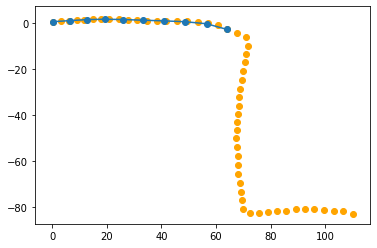

In [3]:
# What to do:
# 1. get better data set - done
# 2. parametrize x(s) and y(s) for road
# 3. better data set should fix data fitting
# 4. better data fitting: curves should match, e.g. curve k ends with derivative k' and curve k+1 should start with derivative k'
# in that way, they are always continuous
# we can set this up (discretely) with ipopt
import bezier
P = 20
nodes = np.asfortranarray(np.transpose(road_center[0:0+P,:]))
curve = bezier.Curve.from_nodes(nodes)
print(curve)
ax = curve.plot(10)
tmp = curve.evaluate_multi(np.linspace(0,1,10))
ax.scatter(road_center[:,0], road_center[:,1], color='orange')
ax.scatter(tmp[0,:], tmp[1,:])


0 3.815431043713564
1 3.8154310437135663
2 6.897890517785942
3 4.00589029852599
4 3.348875434934288
5 3.6246658589368517
6 0.33268143262833866
7 -2.407462308168476
8 -5.381425905574998
9 -2.6785512554432436
10 -4.922860425243141
11 0.33752646084202137
12 0.3395984419639393
13 -2.207756742168605
14 -2.3110619744455505
15 -4.531652156899298
16 -4.93693409911738
17 -15.139624343334068
18 -29.636779759189782
19 -25.33230253619997
20 -25.326064130362724
21 -80.73896765348857
22 -98.67722536691214
23 -99.54409149675736


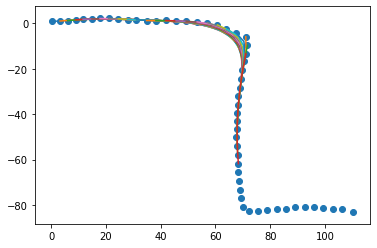

In [4]:
P = 30

for i in range(N_POINTS-P):
    road_b = Roadrunner.to_body_frame(road_center[i:i+P,:], angles[i])

    nodes = np.asfortranarray(np.transpose(road_b))
    curve = bezier.Curve.from_nodes(nodes)
    
    tmp = curve.evaluate_multi(np.linspace(0,9*0.05,10))
    x_b = tmp[0,:]
    y_b = tmp[1,:]
    
    x_b = np.reshape(x_b, (10,1))
    y_b = np.reshape(y_b, (10,1))
    fit_b = np.hstack([x_b, y_b])
    fit_world = Roadrunner.to_world_frame(fit_b, angles[i], offset=road_center[i,:])
    print(i, angles[i]*180/np.pi)
    
    plt.plot(fit_world[:,0], fit_world[:,1], label=str(i))

plt.scatter(road_center[:,0], road_center[:,1])